In [1]:
import time, random, math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Functions

In [2]:
# global parameters
L = 20  # side length
N = L ** 2  # number of sites
q = 2  # number of states per site
J = 1  # ferromagnetic interaction strength

# store metrics
en_historys = {}  # energy
mag_historys = {}  # magnetization
prob_historys = {}  # acceptance probability
n_accepteds = {}  # fraction of accepted

In [3]:
def energy_nn(sigma, J):
    en = 0
    for i in range(L):
        for j in range(L):
            if sigma[i][j] == sigma[i][(j + 1) % L]: en -= J
            if sigma[i][j] == sigma[(i + 1) % L][j]: en -= J
    return en


neighs_cache = [[((i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j))
                 for j in range(L)] for i in range(L)]

def delta_energy_nn(sigma, J, i, j, new_q):
    neighs = neighs_cache[i][j]
    delta_en = 0
    for x, y in neighs:
        if sigma[i][j] == sigma[x][y]:
            delta_en += J
        if new_q == sigma[x][y]:
            delta_en -= J
    return delta_en


def propose_flip(sigma, J):
    idx = random.randint(0, N-1)
    i, j = idx // L, idx % L
    x = random.randint(0, q-1)
    while x == sigma[i][j]:
        x = random.randint(0, q-1)
    return i, j, x


# metropolis acceptance with symmetric proposal. returns a Boolean
def metropolis(delta_en, t):
    if delta_en < 0:
        return True
    if random.uniform(0, 1) < math.exp(- delta_en / t):
        return True
    return False


def critical_temperature(q, J=1):
    return J / math.log(1 + math.sqrt(q))


def get_temps(q, J=1, n1=10, n2=5, dt=0.02, zero=0.2, infinity=5.0):
    crit = critical_temperature(q, J)
    crit = round(crit, 1)

    low = crit - n1 * dt
    high = crit + n1 * dt

    core = np.arange(low, high, dt)
    out1 = np.arange(zero, low, (low - zero ) / n2)
    out2 = np.arange(high, infinity, (infinity - high) / (n2+1))

    core = list(core)
    out1 = list(out1)
    out2 = list(out2)[1:]

    for arr in [core, out1, out2]:
        for i in range(len(arr)):
            arr[i] = round(arr[i], 2)

    return out1, core, out2

In [4]:
# metropolis simulation. Accept parameters specifying system and simulation config. Store results in global dicts.

def MCMC(L, q, t, nstep, burnin, J=1, stride=None):
    # random.seed(42)

    if stride is None:
        stride = 1

    # random initial configuration
    # sigma = np.random.randint(0, q, (L, L))
    sigma = [[random.randint(0, q-1) for _1 in range(L)] for _2 in range(L)]
    en = energy_nn(sigma, J)

    # run a few steps to reach stationarity
    for istep in range(burnin):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            sigma[i][j] = q_new
            # update energy
            en += delta_en

    # prepare to store metrics
    mag_history = [[0 for x in range(q)] for y in range(nstep // stride + 1)]
    mag_history[0] = list(np.bincount(np.array(sigma).reshape(-1), minlength=q))
    # mag_history = np.zeros((q, nstep + 1))
    # mag_history[:, 0] = np.bincount(sigma.reshape(-1), minlength=q)
    prob_history = []
    en_history = []
    n_accepted = 0

    # main loop
    for istep in range(nstep):
        # propose random flip
        i, j, q_new = propose_flip(sigma, J)
        # compute energy difference
        delta_en = delta_energy_nn(sigma, J, i, j, q_new)
        # update probability history
        if delta_en > 0:
            prob_history.append(math.exp(- delta_en / t))
        else:
            prob_history.append(1)
        # prepare magnetization update
        if istep % stride == 0:
            # mag_history[:, istep + 1] = mag_history[:, istep]
            mag_history[istep//stride + 1] = mag_history[istep//stride].copy()
        # metropolis update rule
        if metropolis(delta_en, t):
            # update state
            q_old = sigma[i][j]
            sigma[i][j] = q_new
            n_accepted += 1
            # update energy
            en += delta_en
            # update magnetization history
            if istep % stride == 0:
                # mag_history[q_old, istep + 1] -= 1
                # mag_history[q_new, istep + 1] += 1
                mag_history[istep//stride + 1][q_old] -= 1
                mag_history[istep//stride + 1][q_new] += 1
        # update energy history
        if istep % stride == 0:
            en_history.append(en)

    # save metrics inside global dicts
    en_historys[t] = np.array(en_history)
    mag_historys[t] = np.array(mag_history)[:-1, :]  # to have shape (nstep, q)
    prob_historys[t] = np.array(prob_history)
    n_accepteds[t] = n_accepted

# Simulations

In [5]:
# global parameters
L = 30  # side length
N = L ** 2  # number of sites
q = 8  # number of states per site
J = 1  # ferromagnetic interaction strength

# store metrics
en_historys = {}  # energy
mag_historys = {}  # magnetization
prob_historys = {}  # acceptance probability
n_accepteds = {}  # fraction of accepted

# update cache
neighs_cache = [[((i, (j + 1) % L), (i, (j - 1) % L), ((i + 1) % L, j), ((i - 1) % L, j))
                 for j in range(L)] for i in range(L)]

In [6]:
critical_temperature(q)

0.7449044551221581

In [7]:
get_temps(q)

([0.2, 0.26, 0.32, 0.38, 0.44],
 [0.5,
  0.52,
  0.54,
  0.56,
  0.58,
  0.6,
  0.62,
  0.64,
  0.66,
  0.68,
  0.7,
  0.72,
  0.74,
  0.76,
  0.78,
  0.8,
  0.82,
  0.84,
  0.86,
  0.88],
 [1.58, 2.27, 2.95, 3.63, 4.32])

In [ ]:
burnin = 0
nstep = 10 ** 6
stride = 10

temps = [0.2, 0.5, 0.8, 0.9, 1.0, 1.05, 1.08, 1.10, 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.18, 1.20, 1.30, 1.50, 2.00, 3.00, 5.00, 10.00]

temps = [0.75]

tempo = time.time()
for t in temps:
    print(f'temperature: {t}')
    MCMC(L, q, t, nstep, burnin, J, stride=stride)  # seed 42
    print(f"Time elapsed: {time.time() - tempo}")

temperature: 0.75


In [ ]:
t = 0.75

In [ ]:
mag_history = mag_historys[t]

# print magnetization evolution in time
for i in range(q):
    plt.plot(mag_historys[t][:, i] / N, label=i)
plt.xlabel('step')
plt.ylabel('mags')
plt.show()

In [ ]:
# print maximum absolute value of magnetization in time
max_mag = mag_history.max(axis=1) / N
plt.plot(max_mag)
plt.xlabel('step')
plt.ylabel('magnetization (max)')
print(f"Average magnetization: {max_mag.mean()}")
plt.show()

In [ ]:
en_history = en_historys[t]

# plot energy evolution in time
plt.plot(en_history)
plt.xlabel("step")
plt.ylabel("E")

print(f'Average energy: {en_history.mean()}')
plt.show()

In [ ]:
# compute average energy using consecutive chunks of time. Check stationarity
k = 4
cuts = [i * nstep // k for i in range(k+1)]

for i in range(k):
    print(en_history[cuts[i]:cuts[i+1]].mean())

In [ ]:
prob_history = prob_historys[t]
n_accepted = n_accepteds[t]

# convolve acceptance probabilities with a kernel to improve visualization
window_size = 1000
kernel = np.ones(window_size) / window_size
smoothed_probs = np.convolve(prob_history, kernel, mode='valid')

# plot
plt.plot(smoothed_probs)
plt.xlabel('step')
plt.ylabel('acceptance probability (smoothed)')
plt.yscale('log')

print(f"Fraction of accepted proposals: {n_accepted / nstep}")
plt.show()

In [12]:
avgs = [en_historys[t].mean() for t in temps]

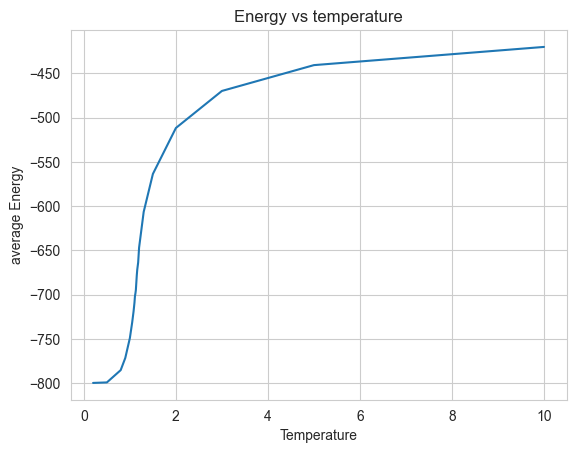

In [157]:
plt.plot(temps, avgs)
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature')
plt.show()

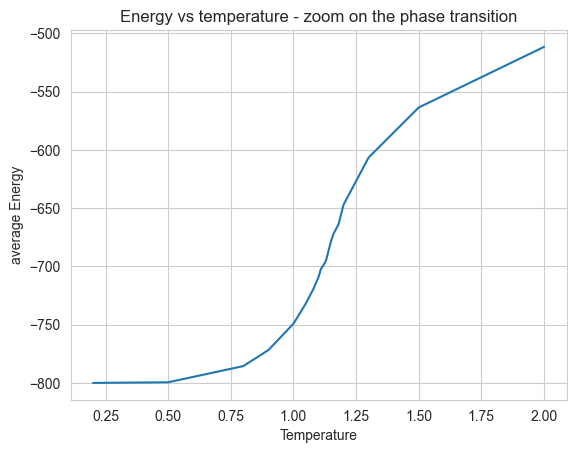

In [196]:
plt.plot(temps[:-3], avgs[:-3])
plt.xlabel('Temperature')
plt.ylabel('average Energy')
plt.title('Energy vs temperature - zoom on the phase transition')
plt.show()

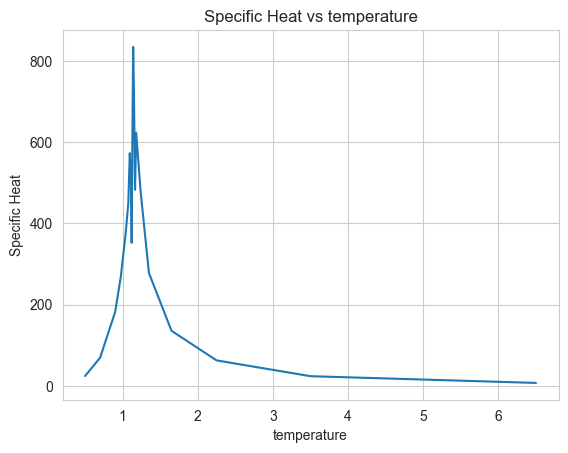

In [210]:
spec_heats = [(avgs[i + 1] - avgs[i]) / (temps[i + 1] - temps[i]) for i in range(0, len(temps) - 1)]
avg_temps = [(temps[i + 1] + temps[i]) / 2 for i in range(0, len(temps) - 1)]

plt.plot(avg_temps, spec_heats)
plt.ylabel('Specific Heat')
plt.xlabel('temperature')
plt.title('Specific Heat vs temperature')
plt.show()